# Backtest with BackTrader

- Rewrite [`SMAVectorBacktester`](https://github.com/rkfcheung/tradev/blob/master/yhilpisch/SMAVectorBacktester.py) into BackTrader by using ChatGPT

In [1]:
import backtrader as bt
import pandas as pd
from pylab import mpl, plt

from strategies import SMAStrategy

## Strategy - Simple Moving Averages

In [2]:
# Initialize the backtrader cerebro engine
cerebro = bt.Cerebro()

In [3]:
# Load data into backtrader
# Assuming CSV has 'Date', 'Open', 'High', 'Low', 'Close', 'Volume' columns
df = pd.read_csv('../data/BankOfEngland-GBPUSD.csv', index_col=0,
                 parse_dates=True, date_format='%d %b %y').dropna().sort_index()
df['Close'] = 1 / df['GBPUSD']
df['Open'] = df['Close']
df['High'] = df['Close']
df['Low'] = df['Close']
df['Volume'] = 0
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-09-02,0.760341,0.760341,0.760341,0.760341,0
2024-09-03,0.763650,0.763650,0.763650,0.763650,0
2024-09-04,0.759821,0.759821,0.759821,0.759821,0
2024-09-05,0.759994,0.759994,0.759994,0.759994,0
2024-09-06,0.759878,0.759878,0.759878,0.759878,0


In [4]:
# Add data to cerebro
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

In [5]:
# Add a strategy
cerebro.addstrategy(SMAStrategy)

0

In [6]:
# Set initial cash
cerebro.broker.setcash(10000)

In [7]:
# Set commission (optional)
cerebro.broker.setcommission(commission=0.001)

In [8]:
# Add analysers
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

In [9]:
# Run the strategy
results = cerebro.run()

SMA1: 36, SMA2: 220 -> Final Value: 19488.23615052261


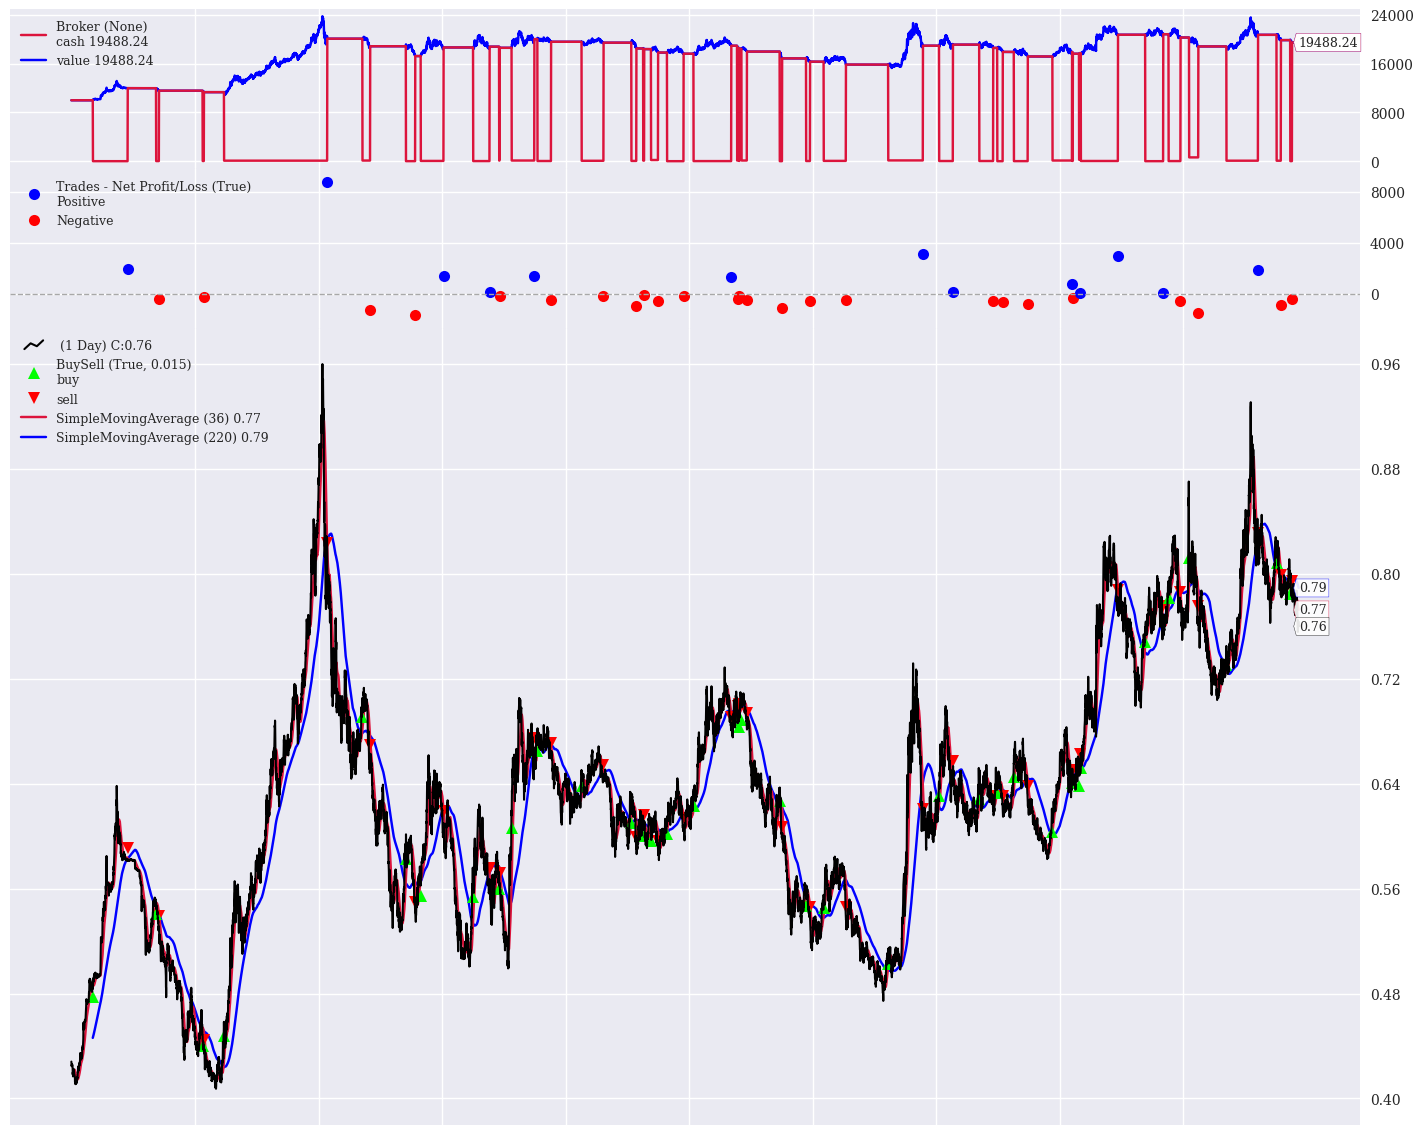

[[<Figure size 1500x1200 with 4 Axes>]]

In [10]:
# Plot the results
%matplotlib inline
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [15, 12]
cerebro.plot(iplot = False)

In [11]:
# Get analysers' results
returns = results[0].analyzers.returns.get_analysis()
sharpe = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()
trades = results[0].analyzers.trades.get_analysis()

# Print summary
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")
print(f"Gross Return: {returns['rtot']*100:.2f}%")
print(f"Annual Return: {returns['rnorm100']:.2f}%")
print(f"Sharpe Ratio: {sharpe['sharperatio']}")
print(f"Max Drawdown: {drawdown.max.drawdown:.2f}%")
print(f"Total Trades: {trades.total.closed}")

Final Portfolio Value: 19488.23615052261
Gross Return: 66.72%
Annual Return: 1.35%
Sharpe Ratio: 0.07890126270263524
Max Drawdown: 35.70%
Total Trades: 38
